In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# Define ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, use_dropout=False):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load CIFAR-10 & CIFAR-100 datasets
def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset_10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset_10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    trainset_100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    testset_100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    return DataLoader(trainset_10, batch_size=batch_size, shuffle=True), DataLoader(testset_10, batch_size=batch_size, shuffle=False), DataLoader(trainset_100, batch_size=batch_size, shuffle=True), DataLoader(testset_100, batch_size=batch_size, shuffle=False)

# Initialize data loaders
trainloader_10, testloader_10, trainloader_100, testloader_100 = get_data_loaders()

# Training function with plots
def train_model(model, trainloader, testloader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(trainloader))
        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(correct / total * 100)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

    return train_losses, val_losses, val_accuracies


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Training ResNet-11 on CIFAR-10...
Epoch 1/10 - Train Loss: 1.3555, Val Loss: 1.2516, Val Acc: 56.73%
Epoch 2/10 - Train Loss: 0.9273, Val Loss: 0.9309, Val Acc: 67.26%
Epoch 3/10 - Train Loss: 0.7393, Val Loss: 0.7153, Val Acc: 75.25%
Epoch 4/10 - Train Loss: 0.6178, Val Loss: 0.6565, Val Acc: 76.81%
Epoch 5/10 - Train Loss: 0.5423, Val Loss: 0.6360, Val Acc: 78.16%
Epoch 6/10 - Train Loss: 0.4831, Val Loss: 0.6196, Val Acc: 79.26%
Epoch 7/10 - Train Loss: 0.4415, Val Loss: 0.6063, Val Acc: 79.83%
Epoch 8/10 - Train Loss: 0.3970, Val Loss: 0.5065, Val Acc: 83.17%
Epoch 9/10 - Train Loss: 0.3693, Val Loss: 0.4918, Val Acc: 83.15%
Epoch 10/10 - Train Loss: 0.3410, Val Loss: 0.4146, Val Acc: 86.17%


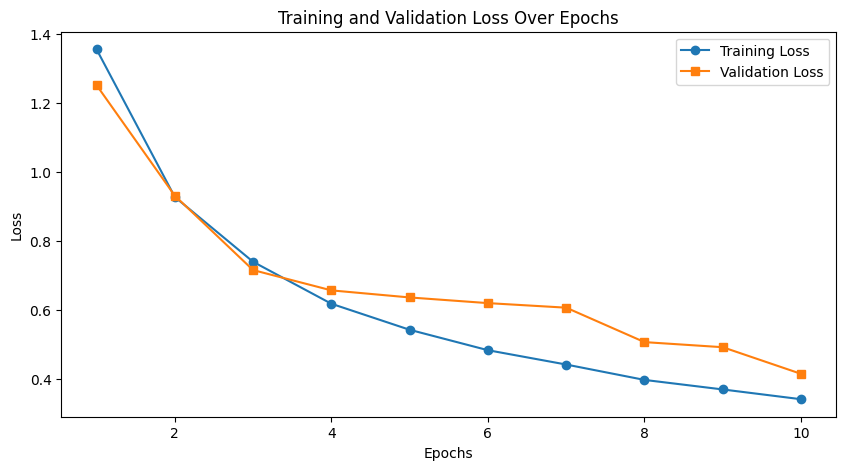

Training ResNet-18 on CIFAR-10...
Epoch 1/10 - Train Loss: 1.4799, Val Loss: 1.3329, Val Acc: 52.88%
Epoch 2/10 - Train Loss: 1.0091, Val Loss: 1.0645, Val Acc: 63.03%
Epoch 3/10 - Train Loss: 0.8008, Val Loss: 0.9627, Val Acc: 67.06%
Epoch 4/10 - Train Loss: 0.6549, Val Loss: 0.7162, Val Acc: 75.54%
Epoch 5/10 - Train Loss: 0.5675, Val Loss: 0.6161, Val Acc: 78.97%
Epoch 6/10 - Train Loss: 0.4970, Val Loss: 0.5886, Val Acc: 79.90%
Epoch 7/10 - Train Loss: 0.4483, Val Loss: 0.5119, Val Acc: 82.50%
Epoch 8/10 - Train Loss: 0.4135, Val Loss: 0.5478, Val Acc: 82.14%
Epoch 9/10 - Train Loss: 0.3720, Val Loss: 0.4952, Val Acc: 83.18%
Epoch 10/10 - Train Loss: 0.3414, Val Loss: 0.4397, Val Acc: 84.91%


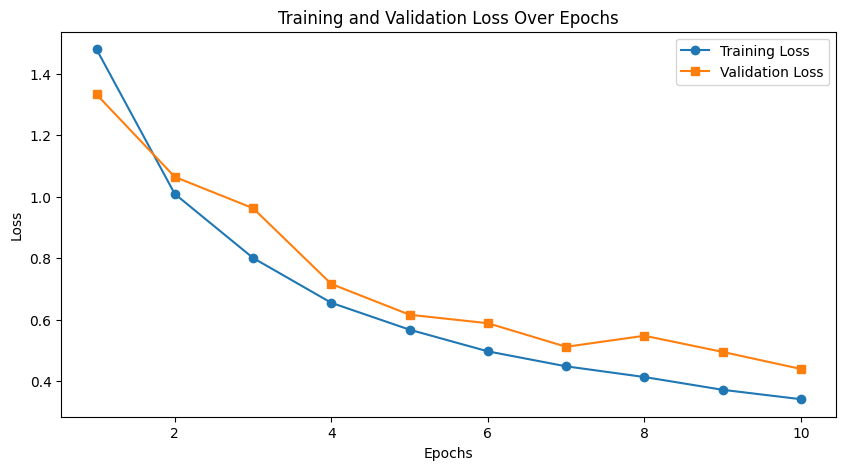

Training ResNet-11 on CIFAR-100...
Epoch 1/10 - Train Loss: 3.5769, Val Loss: 3.2628, Val Acc: 20.06%
Epoch 2/10 - Train Loss: 2.7797, Val Loss: 2.6657, Val Acc: 31.59%
Epoch 3/10 - Train Loss: 2.3439, Val Loss: 2.4733, Val Acc: 35.46%
Epoch 4/10 - Train Loss: 2.0465, Val Loss: 2.1591, Val Acc: 42.70%
Epoch 5/10 - Train Loss: 1.8229, Val Loss: 1.8741, Val Acc: 48.88%
Epoch 6/10 - Train Loss: 1.6402, Val Loss: 1.7708, Val Acc: 50.71%
Epoch 7/10 - Train Loss: 1.4978, Val Loss: 1.7213, Val Acc: 52.65%
Epoch 8/10 - Train Loss: 1.3642, Val Loss: 1.6209, Val Acc: 55.15%
Epoch 9/10 - Train Loss: 1.2620, Val Loss: 1.5355, Val Acc: 57.41%
Epoch 10/10 - Train Loss: 1.1659, Val Loss: 1.5749, Val Acc: 56.72%


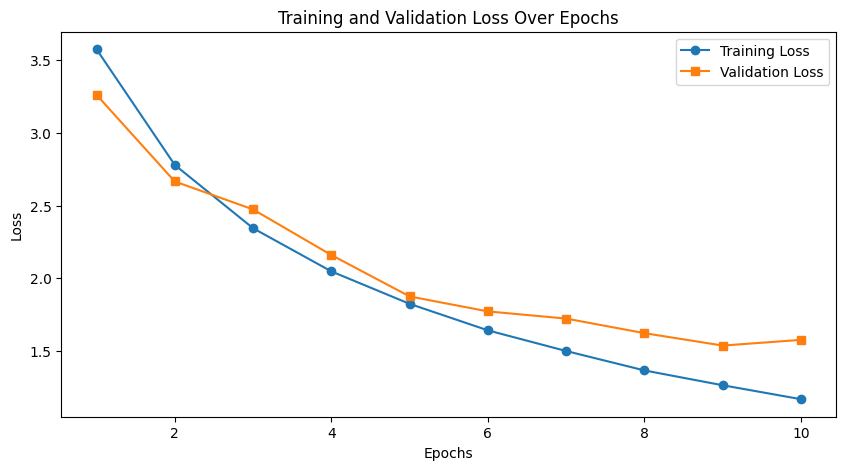

Training ResNet-18 on CIFAR-100...
Epoch 1/10 - Train Loss: 3.7723, Val Loss: 3.3226, Val Acc: 19.10%
Epoch 2/10 - Train Loss: 2.9789, Val Loss: 2.8284, Val Acc: 27.55%
Epoch 3/10 - Train Loss: 2.4844, Val Loss: 2.5260, Val Acc: 34.92%
Epoch 4/10 - Train Loss: 2.1125, Val Loss: 2.3033, Val Acc: 40.07%
Epoch 5/10 - Train Loss: 1.8541, Val Loss: 1.9695, Val Acc: 46.77%
Epoch 6/10 - Train Loss: 1.6574, Val Loss: 1.8735, Val Acc: 49.08%
Epoch 7/10 - Train Loss: 1.4835, Val Loss: 1.7165, Val Acc: 52.89%
Epoch 8/10 - Train Loss: 1.3447, Val Loss: 1.6220, Val Acc: 54.60%
Epoch 9/10 - Train Loss: 1.2252, Val Loss: 1.5413, Val Acc: 57.69%
Epoch 10/10 - Train Loss: 1.1179, Val Loss: 1.4913, Val Acc: 58.52%


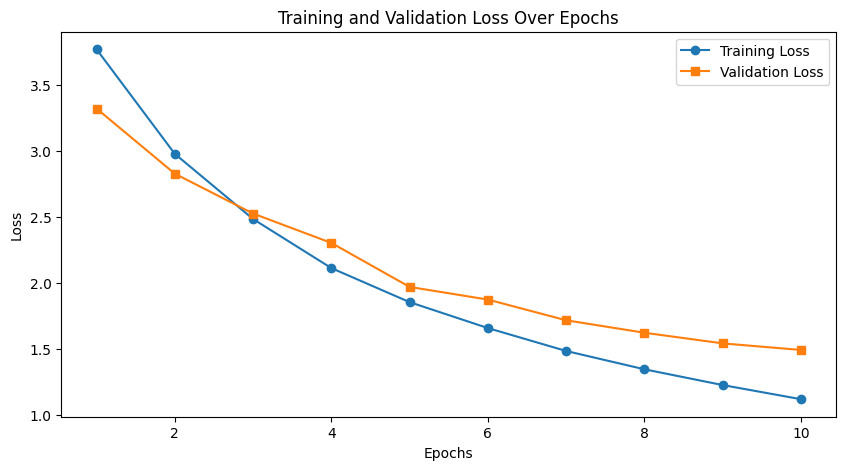

In [ ]:
# Create ResNet-11 and ResNet-18 models
model_resnet11 = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=10, use_dropout=False)
model_resnet18 = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10, use_dropout=False)

# Train ResNet-11 on CIFAR-10
print("Training ResNet-11 on CIFAR-10...")
train_losses_11, val_losses_11, val_acc_11 = train_model(model_resnet11, trainloader_10, testloader_10)

# Train ResNet-18 on CIFAR-10
print("Training ResNet-18 on CIFAR-10...")
train_losses_18, val_losses_18, val_acc_18 = train_model(model_resnet18, trainloader_10, testloader_10)

# Train ResNet-11 on CIFAR-100
model_resnet11_100 = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=100, use_dropout=False)
model_resnet18_100 = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=100, use_dropout=False)

print("Training ResNet-11 on CIFAR-100...")
train_losses_11_100, val_losses_11_100, val_acc_11_100 = train_model(model_resnet11_100, trainloader_100, testloader_100)

print("Training ResNet-18 on CIFAR-100...")
train_losses_18_100, val_losses_18_100, val_acc_18_100 = train_model(model_resnet18_100, trainloader_100, testloader_100)
